# 로지스틱 회귀 분석을 통한 당뇨병 예측

## 특징들

임신, 포도당, 혈압, 피부 두께, 인슐린, 당뇨병 혈통 기능, 나이 및 결과(질병 (1)이 있거나 0이 아닌 경우)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, confusion_matrix, classification_report, plot_roc_curve

In [3]:
df=pd.read_csv('diabetes.csv')

In [4]:
#출력 포맷, 과학적 표기법 사용
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
#display.max_rows 및 display.max_lows는 프레임이 예쁘게 인쇄될 때 표시되는 
#최대 행 및 열 수를 설정합니다. 잘린 선은 줄임표로 바뀝니다.
pd.set_option('display.float_format',lambda x:'%.3f' % x)#소수점 설정
pd.set_option('display.width',170)#너비설정

df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0
6,3,78,50,32,88,31.000,0.248,26,1
7,10,115,0,0,0,35.300,0.134,29,0
8,2,197,70,45,543,30.500,0.158,53,1
9,8,125,96,0,0,0.000,0.232,54,1


In [5]:
df.shape

(768, 9)

먼저 데이터를 살펴봅니다.

In [20]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [21]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

## Data PREP & EDA

임계값 조정 및 특이치 확인

In [22]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [23]:
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

데이터 세트의 변수를 범주형 및 숫자로 구분할 수 있었습니다.

In [24]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

이상값이 있는 기능은 무엇입니까?

In [25]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)

for col in num_cols:
    print(col,check_outlier(df,col))

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


특이치를 상한 및 하한으로 대체

In [27]:
def replace_with_thresholds(dataframe,variable):
    low_limit, up_limit = outlier_thresholds(dataframe,variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [28]:
for col in num_cols:
    replace_with_thresholds(df,col)

이상치 재검사

In [30]:
for col in num_cols:
    print(col, check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


누락된 값은 어떻게 해야 합니까?

In [31]:
df.isnull().values.any()#any() : 하나라도 True인게 있으면 True

False

In [32]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,0
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1


데이터의 0값을 중위수로 대체했습니다.

In [34]:
def zeros_values(df):
    median = df[num_cols].median()
    df[num_cols] = df[num_cols].replace(to_replace=0, value=median)
zeros_values(df)
df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,30.500,33.600,0.627,50.000,1
1,1.000,85.000,66.000,29.000,30.500,26.600,0.351,31.000,0
2,8.000,183.000,64.000,23.000,30.500,23.300,0.672,32.000,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,3.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1
5,5.000,116.000,74.000,23.000,30.500,25.600,0.201,30.000,0
6,3.000,78.000,50.000,32.000,88.000,31.000,0.248,26.000,1
7,10.000,115.000,35.000,23.000,30.500,35.300,0.134,29.000,0
8,2.000,197.000,70.000,45.000,318.125,30.500,0.158,53.000,1
9,8.000,125.000,96.000,23.000,30.500,13.350,0.232,54.000,1


## Feature Engineering

연령 변수를 분류하다

In [35]:
df.loc[(df['Age']<18),'NEW_AGE']='Young'
df.loc[(df['Age']>18) & (df['Age']<56),'NEW_AGE']='Mature'
df.loc[(df['Age']>56),'NEW_AGE']='Old'

인슐린 값 분류(정상 및 비정상)

In [36]:
df.loc[(df['Insulin']>=120),'NEW_INSULIN']='Anormal'
df.loc[(df['Insulin']<120),'NEW_INSULIN']='normal'

BMI(비만, 건강, 과체중, 비만)를 분류합니다.

In [37]:
df.loc[(df['BMI']<18.5), 'NEW_BMI']='under'
df.loc[(df['BMI']>=18.5) & (df['BMI']<=24.9), 'NEW_BMI']='healthy'
df.loc[(df['BMI']>=25) & (df['BMI']<=29.9), 'NEW_BMI']='over'
df.loc[(df['BMI']>=30), 'NEW_BMI']='obese'

혈압 분류

In [38]:
df.loc[(df['BloodPressure'] < 79), 'NEW_BLOODPRESSURE']='Normal'
df.loc[(df['BloodPressure'] > 79) & (df['BloodPressure'] < 89) , 'NEW_BLOODPRESSURE']='Hypertension_S1'
df.loc[(df['BloodPressure'] > 89) & (df['BloodPressure'] < 123) , 'NEW_BLOODPRESSURE']='Hypertension_S2'

포도당 분류

In [39]:
df.loc[(df['Glucose']<70), 'NEW_GLUCOSE'] = 'Low'
df.loc[(df['Glucose']>=70) & (df['Glucose']<99), 'NEW_GLUCOSE'] = 'Normal'
df.loc[(df['Glucose']>=99) & (df['Glucose']<125), 'NEW_GLUCOSE'] = 'Secret'
df.loc[(df['Glucose']>=126) & (df['Glucose']<200), 'NEW_GLUCOSE'] = 'High'

In [40]:
df['DiaPedFunc']=pd.qcut(df['DiabetesPedigreeFunction'],3,labels=['Low','Medium','High'])

In [41]:
df.loc[df['Pregnancies']==0,'NEW_PREGNANCIES']='NoPregnancy'
df.loc[((df['Pregnancies']>=0) & (df['Pregnancies']<=4)),'NEW_PREGNANCIES']='NormalPregnancy'
df.loc[(df['Pregnancies']>4),'NEW_PREGNANCIES']='OverPregnancy'

In [42]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE,NEW_INSULIN,NEW_BMI,NEW_BLOODPRESSURE,NEW_GLUCOSE,DiaPedFunc,NEW_PREGNANCIES
0,6.000,148.000,72.000,35.000,30.500,33.600,0.627,50.000,1,Mature,normal,obese,Normal,High,High,OverPregnancy
1,1.000,85.000,66.000,29.000,30.500,26.600,0.351,31.000,0,Mature,normal,over,Normal,Normal,Medium,NormalPregnancy
2,8.000,183.000,64.000,23.000,30.500,23.300,0.672,32.000,1,Mature,normal,healthy,Normal,High,High,OverPregnancy
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,Mature,normal,over,Normal,Normal,Low,NormalPregnancy
4,3.000,137.000,40.000,35.000,168.000,43.100,1.200,33.000,1,Mature,Anormal,obese,Normal,High,High,NormalPregnancy


In [44]:
df.shape

(768, 16)

데이터 유형 개체 및 2와 같은 고유 값에 Label encoder 사용

In [46]:
def label_encoder(dataframe,binary_col): 
    labelencoder=LabelEncoder()
    dataframe[binary_col]=labelencoder.fit_transform(dataframe[binary_col].astype(str))
    return dataframe

binary_cols=[col for col in df.columns if df[col].dtypes=='O' and len(df[col].unique()) == 2]

for col in df.columns:
    label_encoder(df,col)

범주형 데이터에 one-hot-encoding 사용

In [48]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= len(df[col].unique()) > 2]

one_hot_encoder(df, ohe_cols, drop_first=True)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN,NEW_PREGNANCIES,NEW_AGE_1,NEW_AGE_2,NEW_BMI_1,NEW_BMI_2,NEW_BMI_3,NEW_BLOODPRESSURE_1,NEW_BLOODPRESSURE_2,NEW_GLUCOSE_1,NEW_GLUCOSE_2,NEW_GLUCOSE_3,NEW_GLUCOSE_4,DiaPedFunc_1,DiaPedFunc_2
0,10,48,25,25,94,123,350,29,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,121,22,19,94,62,196,10,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1
2,12,83,20,13,94,30,368,11,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,125,22,13,153,77,53,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0
4,7,37,7,25,39,209,489,12,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,9,16,26,13,94,53,80,9,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0
6,7,114,11,22,148,103,118,5,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0
7,1,15,5,13,94,140,23,8,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0
8,6,95,24,35,99,99,44,32,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
9,12,25,40,13,94,0,103,33,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0


데이터 확장,

RobustScaler는 특이치를 견고히 하기 때문에 사용했습니다.

In [49]:
rs=RobustScaler()
df[num_cols]=rs.fit_transform(df[num_cols])

대상 변수 및 특성 정의

In [50]:
y=df['Outcome']
X=df.drop(['Outcome'],axis=1)

데이터를 train 및 테스트별로 분할합니다. 테스트 크기는 20%, train 크기는 80%입니다.

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=1)

모델 구축 및 교육

In [52]:
log_model=LogisticRegression().fit(X_train,y_train)

train 세트를 사용하여 모델의 성공 평가

In [53]:
y_pred=log_model.predict(X_train)
accuracy_score(y_train,y_pred)

0.747557003257329

In [54]:
y_prob=log_model.predict_proba(X_test)[:,1]
y_pred=log_model.predict(X_test)

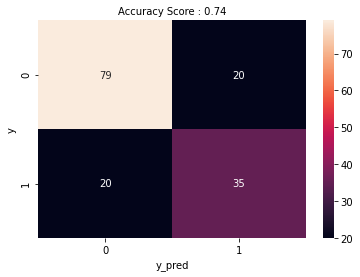

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt
def plot_confusion_matrix(y,y_pred):
    acc=round(accuracy_score(y,y_pred),2)
    cm=confusion_matrix(y,y_pred)
    sns.heatmap(cm,annot=True,fmt='.0f')
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score : {0}'.format(acc),size=10)
    plt.show()
    
plot_confusion_matrix(y_test,y_pred)

테스트 세트를 사용하여 모델 정확도 평가

In [57]:
#accuracy
accuracy_score(y_test,y_pred)

0.7402597402597403

In [58]:
#precision
precision_score(y_test,y_pred)

0.6363636363636364

In [59]:
#recall
recall_score(y_test,y_pred)

0.6363636363636364

In [60]:
#f1
f1_score(y_test,y_pred)

0.6363636363636364

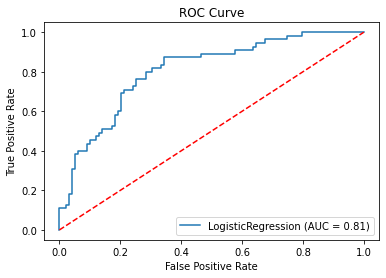

In [61]:
#ROC Curve
plot_roc_curve(log_model,X_test,y_test)
plt.title('ROC Curve')
plt.plot([0,1],[0,1],'r--')
plt.show()

In [62]:
#auc
roc_auc_score(y_test,y_prob)

0.8064279155188245

In [63]:
#classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        99
           1       0.64      0.64      0.64        55

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.74      0.74       154

